### Overview

Here, we evaluate how well our communities agree with curated categories from each database. We do the following steps:
1. load all pathways in our pathway graph along with both the preexisting curated labels and our learned community assignments.
2. Create a heatmap for each database where we compare curated categories with our learned communities
3. Create a combined heatmap with all curated categories across databases compared with our learned communities

In [2]:
import networkx as nx

import numpy as np
import os
import copy
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

import utils

## Load gene sets & curated labels

In [3]:
acronym_to_folder = {"KEGG": "c2.all.v7.0.symbols_JustK", "REACTOME":"c2.all.v7.0.symbols_JustR",
                  "GO_BP": "c5.bp.v7.0.symbols_SHORT", "GO_CC": "c5.cc.v7.0.symbols", "GO_MF": "c5.mf.v7.0.symbols"}
folder_to_acronym = utils.reverse_dict(acronym_to_folder, assume_unique = True)
pway_subfolders =  'c2.all.v7.0.symbols_JustK-c2.all.v7.0.symbols_JustR-c5.bp.v7.0.symbols_SHORT-c5.mf.v7.0.symbols'
gsets_folders = pway_subfolders.split("-")
gsets_acronyms = [folder_to_acronym[x] for x in gsets_folders]

In [4]:
gmts, true_labels_unique, true_labels, true_labels_names= utils.load_curated_labels(pway_dbs=gsets_acronyms)
pathway_names_curated_categories =  np.hstack([true_labels_names[name] for name in gsets_acronyms])

Number of true categories:  38
[ 1.  3.  4.  5.  6.  7.  8.  9. 16. 17. 21. 22. 23. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 54. 55.
 56. 57.]
Number of true categories:  27
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]
Number of true categories:  64
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
Number of true categories:  69
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68.]


In [5]:
pathways = {}
pway_indices = {}

cur_idx = 0
for foldername in gsets_folders:
    name = folder_to_acronym[foldername]
    pathways[name] = np.loadtxt('../adj_matrices/%s/pathway_names.txt'%foldername, dtype=str)
    pway_indices[name] = np.arange(cur_idx, cur_idx + len(pathways[name])).astype(int)
    cur_idx += len(pathways[name])
    
total_num_pathways = np.sum([len(x) for x in pathways.values()])

pathway_names = np.hstack([pathways[name] for name in gsets_acronyms])

## load community labels

In [6]:
new_com_df = pd.read_csv("../Full_graph_louvain_with_weights_community_labels/0.4/labels.tsv", delimiter="\t", names=["pathways", "com"])
new_com_df = new_com_df.merge(pd.DataFrame(pathway_names.reshape(len(pathway_names),1), columns=["pathways"]), how="right", on="pathways")
coms = new_com_df["com"].values

### Get  NMIs for each database

In [7]:

SCORING_FUNCTION =  normalized_mutual_info_score
stacked_curated = []
stacked_coms = []


NMI_score = {}
for key in gmts.keys():
    
    tmp = gmts[key].merge(new_com_df, left_on="names", right_on="pathways")
    tmp['curated'] = true_labels[key]
        
    NMI_score[key] = SCORING_FUNCTION(tmp['com'], tmp['curated'], average_method='arithmetic')
    print(key, NMI_score[key])
    
    stacked_curated.append(tmp["curated"].values)
    stacked_coms.append(tmp["com"].values)

NMI_score["overall"] = SCORING_FUNCTION(np.hstack(stacked_coms), np.hstack(stacked_curated), average_method='arithmetic')
print("overall", NMI_score["overall"])

KEGG 0.6198849515012462
REACTOME 0.42909697969090227
GO_BP 0.3277291423875328
GO_MF 0.41067287874421743
overall 0.2962906948497231


### Communities vs curated heatmap

In [8]:
coms_w_curated = copy.deepcopy(new_com_df)
coms_w_curated["curated"] = np.hstack([["%s~%s"%(name, x) for x in true_labels_names[name]] for name in gsets_acronyms])
com_v_curated = pd.crosstab(coms_w_curated["com"], coms_w_curated["curated"])

In [9]:
def format_annot(x, decs=2):
    if x==0:
        return("")
    else:
        return(str(x))

In [10]:
import matplotlib as mpl

tab10_cmap = mpl.cm.get_cmap("tab10")

database_colors = {"KEGG":mpl.colors.to_hex(tab10_cmap(1)),
"REACTOME":mpl.colors.to_hex(tab10_cmap(8)),
"GO_BP":mpl.colors.to_hex(tab10_cmap(6)),
"GO_MF":mpl.colors.to_hex(tab10_cmap(9))}

sns.set_style("white",  {'figure.facecolor': 'white'})


### Single heatmap for each database

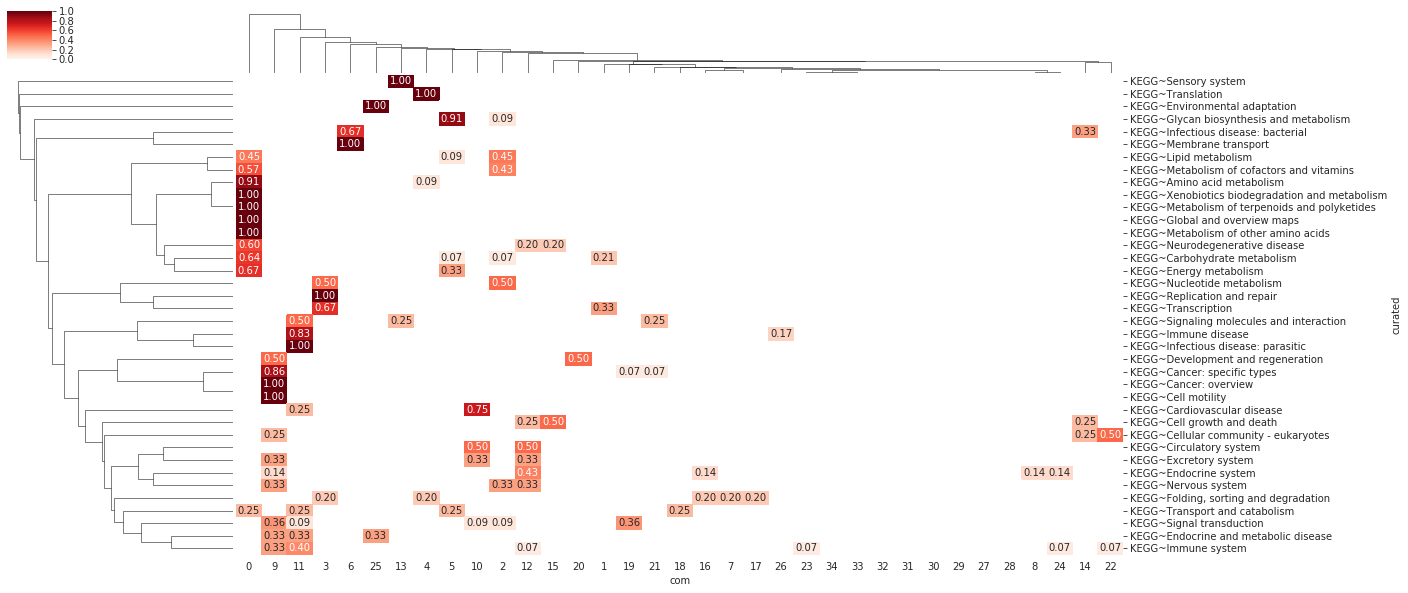

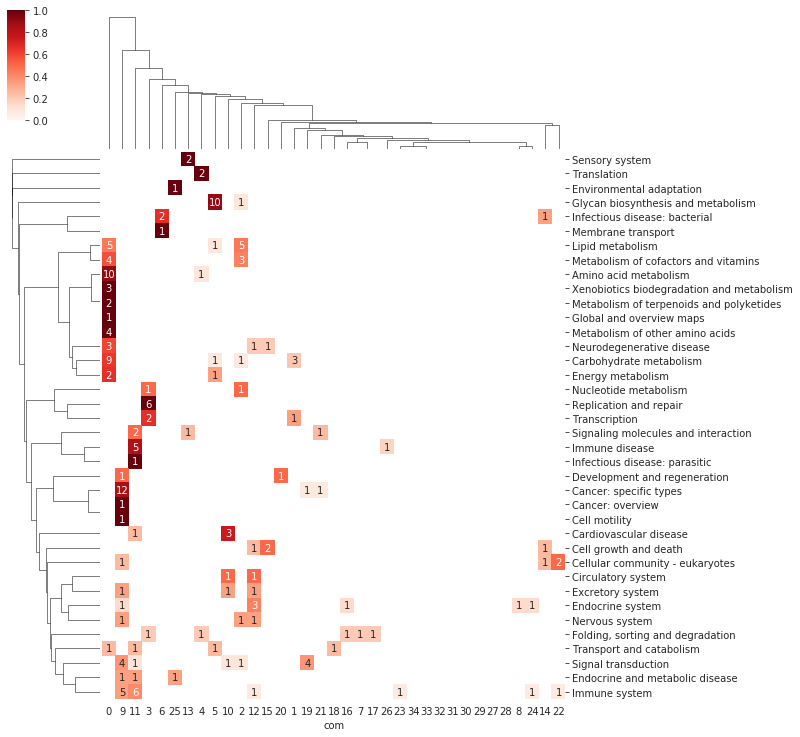

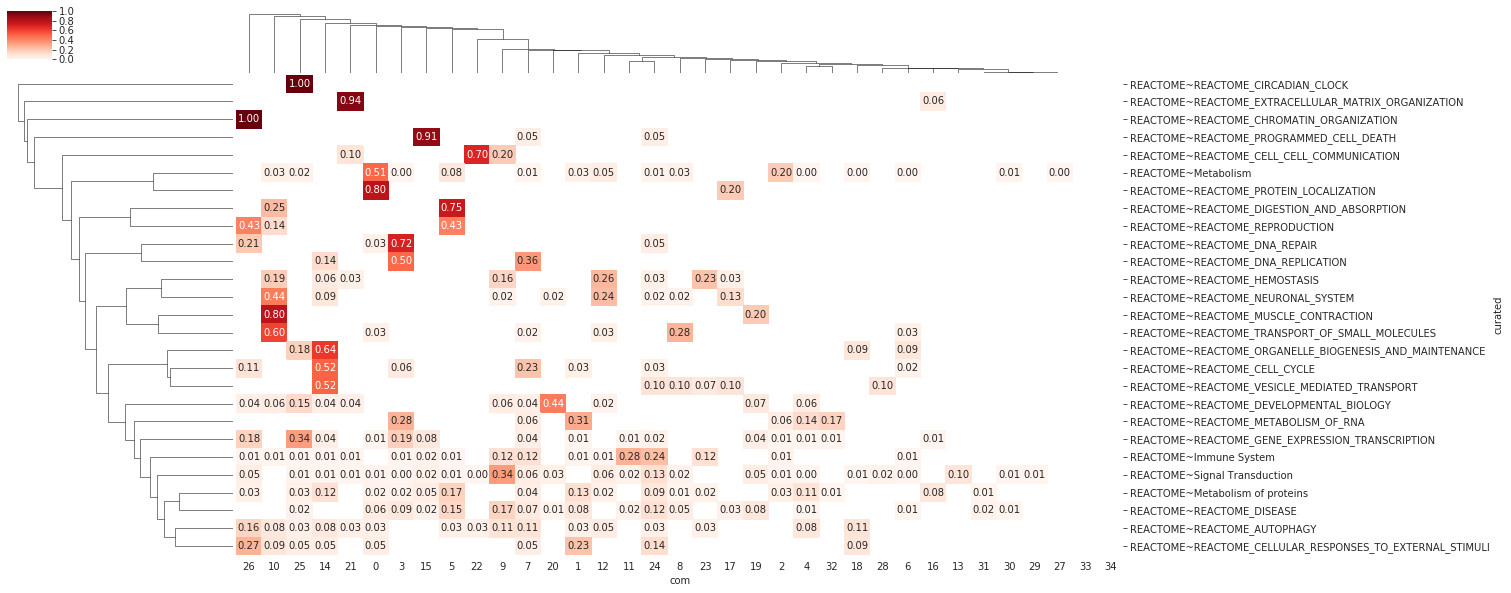

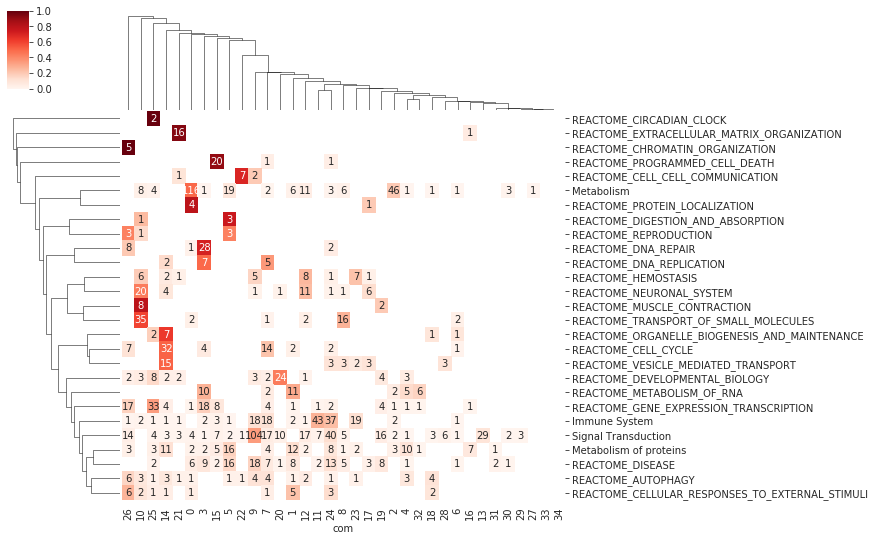

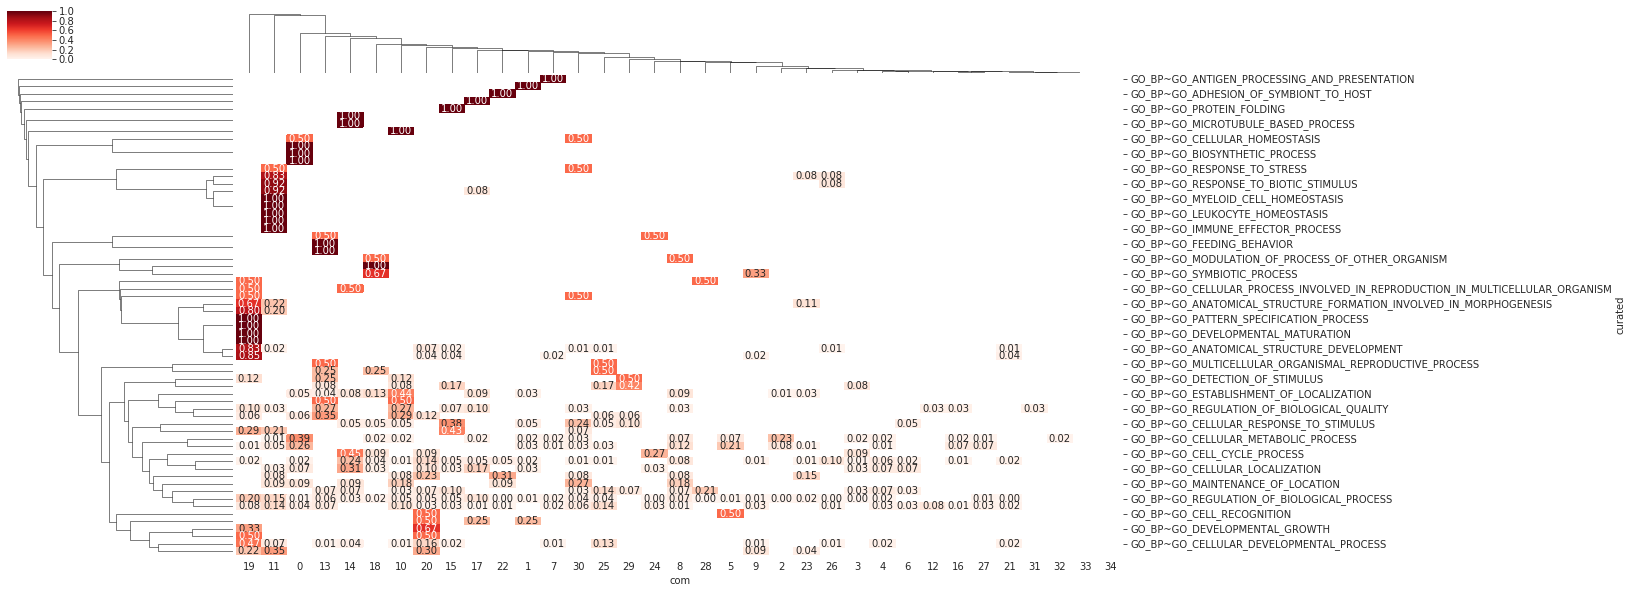

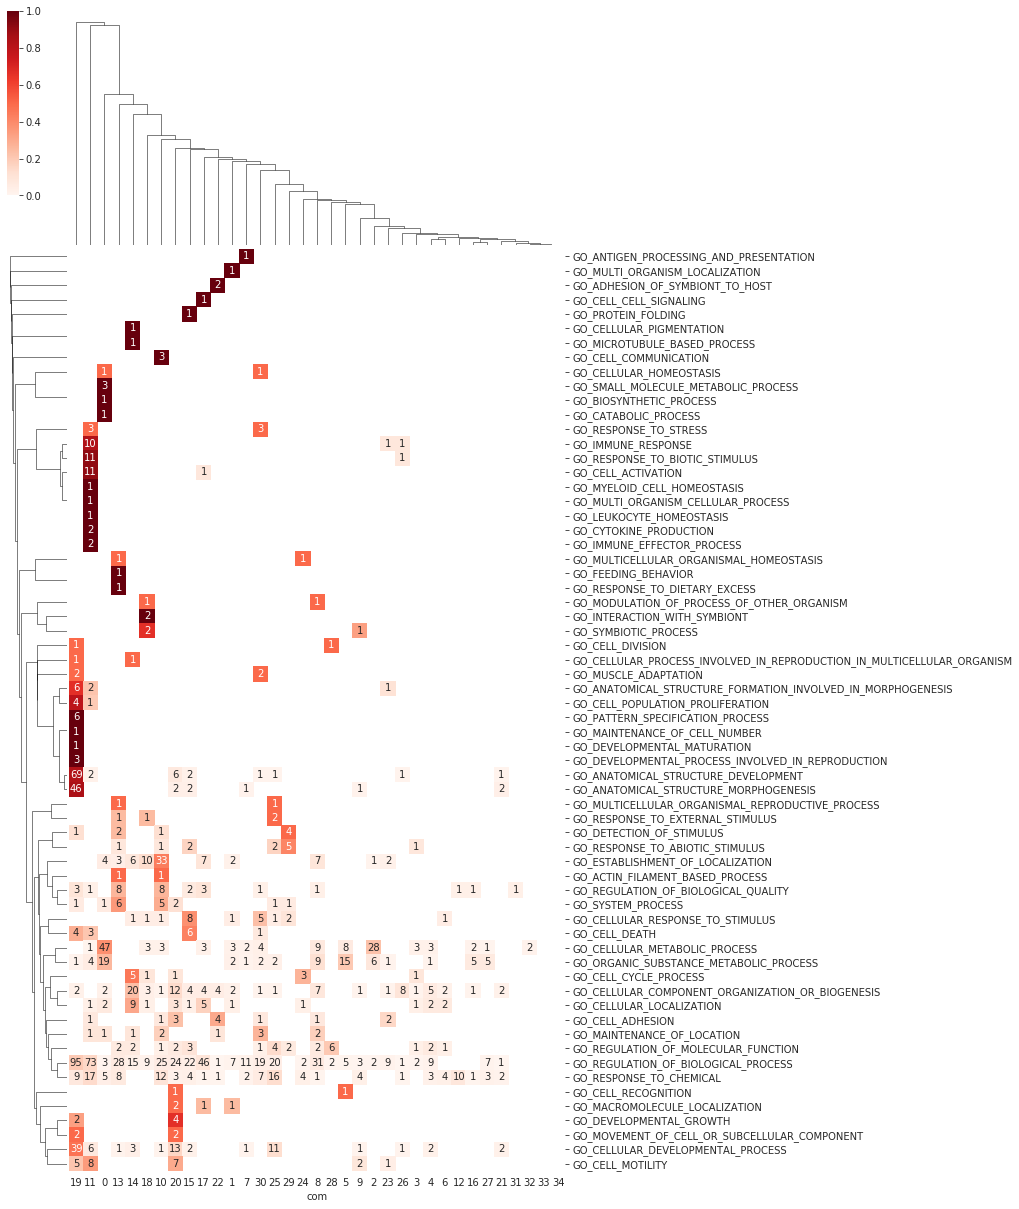

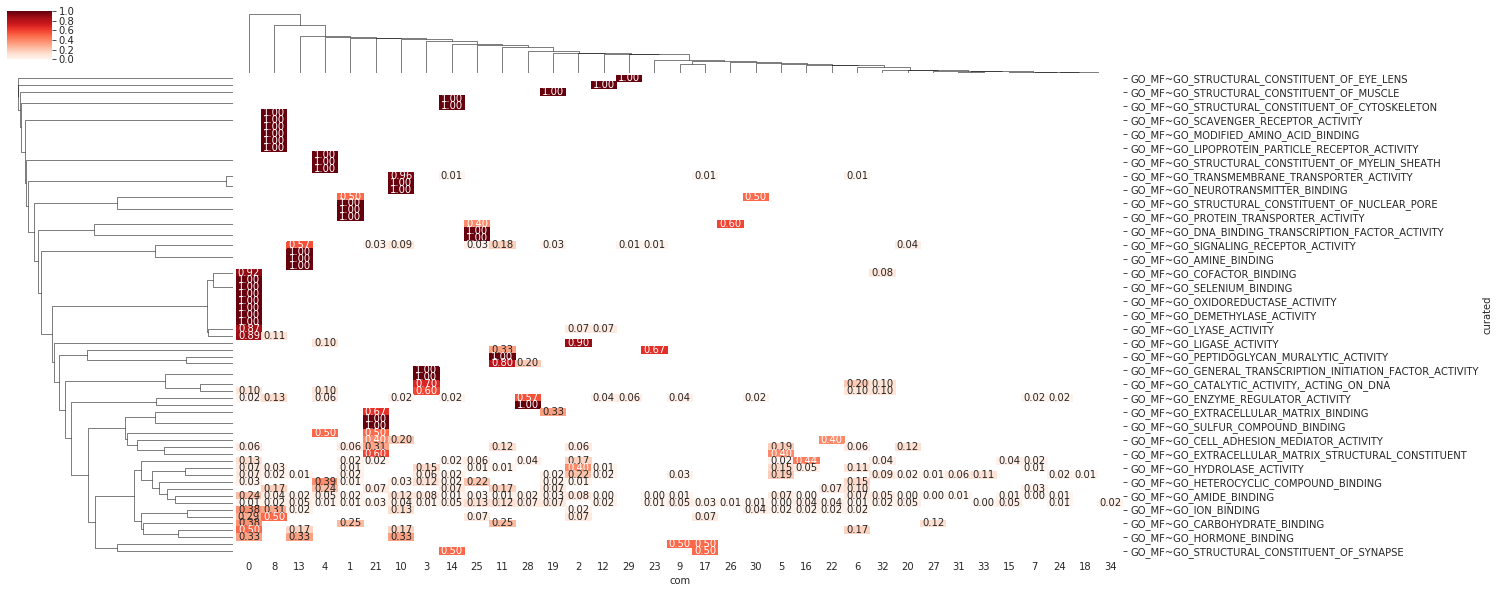

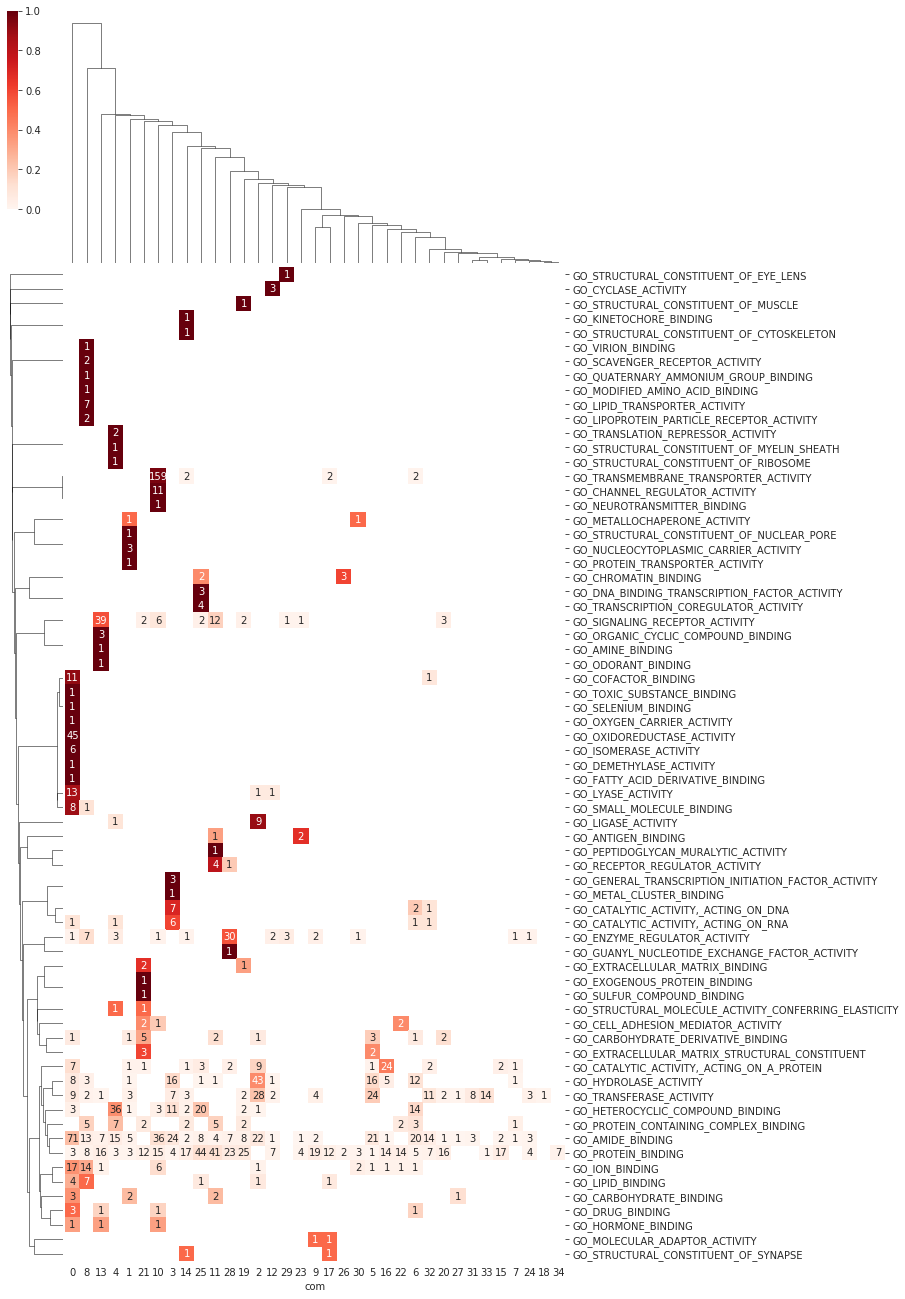

In [12]:
for db in gmts.keys():
    cols_to_idx = np.array(com_v_curated.columns)[[x.split("~")[0] == db for x in com_v_curated.columns]]

    toplot = (com_v_curated[cols_to_idx]/com_v_curated[cols_to_idx].sum()).T

    g_0 = sns.clustermap(toplot, cmap="Reds", figsize=(20,10), mask=(toplot==0), annot=True, fmt=".2f", 
                   annot_kws={"fontsize":10, "fontfamily": "sans-serif"})


    new_row_idx = g_0.dendrogram_row.reordered_ind
    new_row_order = np.array(toplot.index)[new_row_idx]
    new_col_idx = g_0.dendrogram_col.reordered_ind
    new_col_order = np.array(toplot.columns)[new_col_idx]

    labels = copy.deepcopy(com_v_curated.T)
    for col in labels.columns:
        labels[col] = labels[col].apply(lambda x: format_annot(x,2))

    toplot.index = [x.split("~")[1] for x in toplot.index]
    g = sns.clustermap(toplot,cmap="Reds", figsize=(10,len(toplot)/3), mask=(toplot==0), annot=labels.loc[new_row_order, new_col_order],
                       fmt="s",  annot_kws={"fontsize":10, "fontfamily": "sans-serif"}) 


### Combined heatmap for entire graph

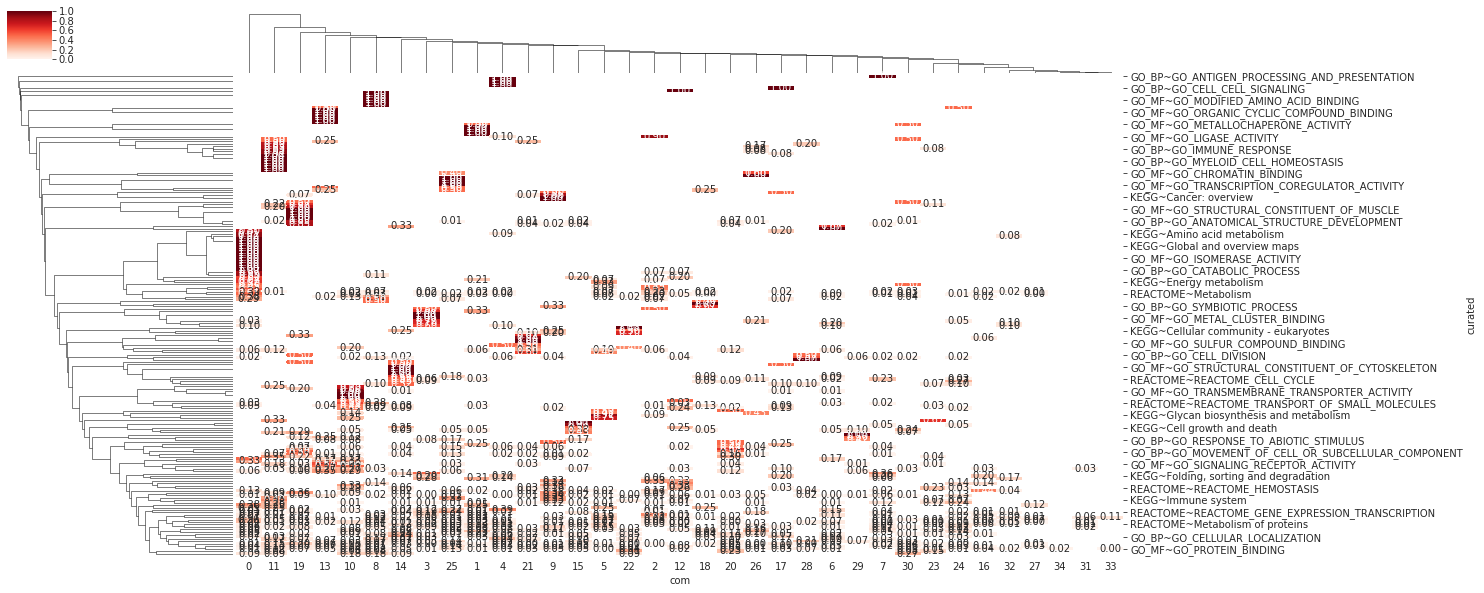

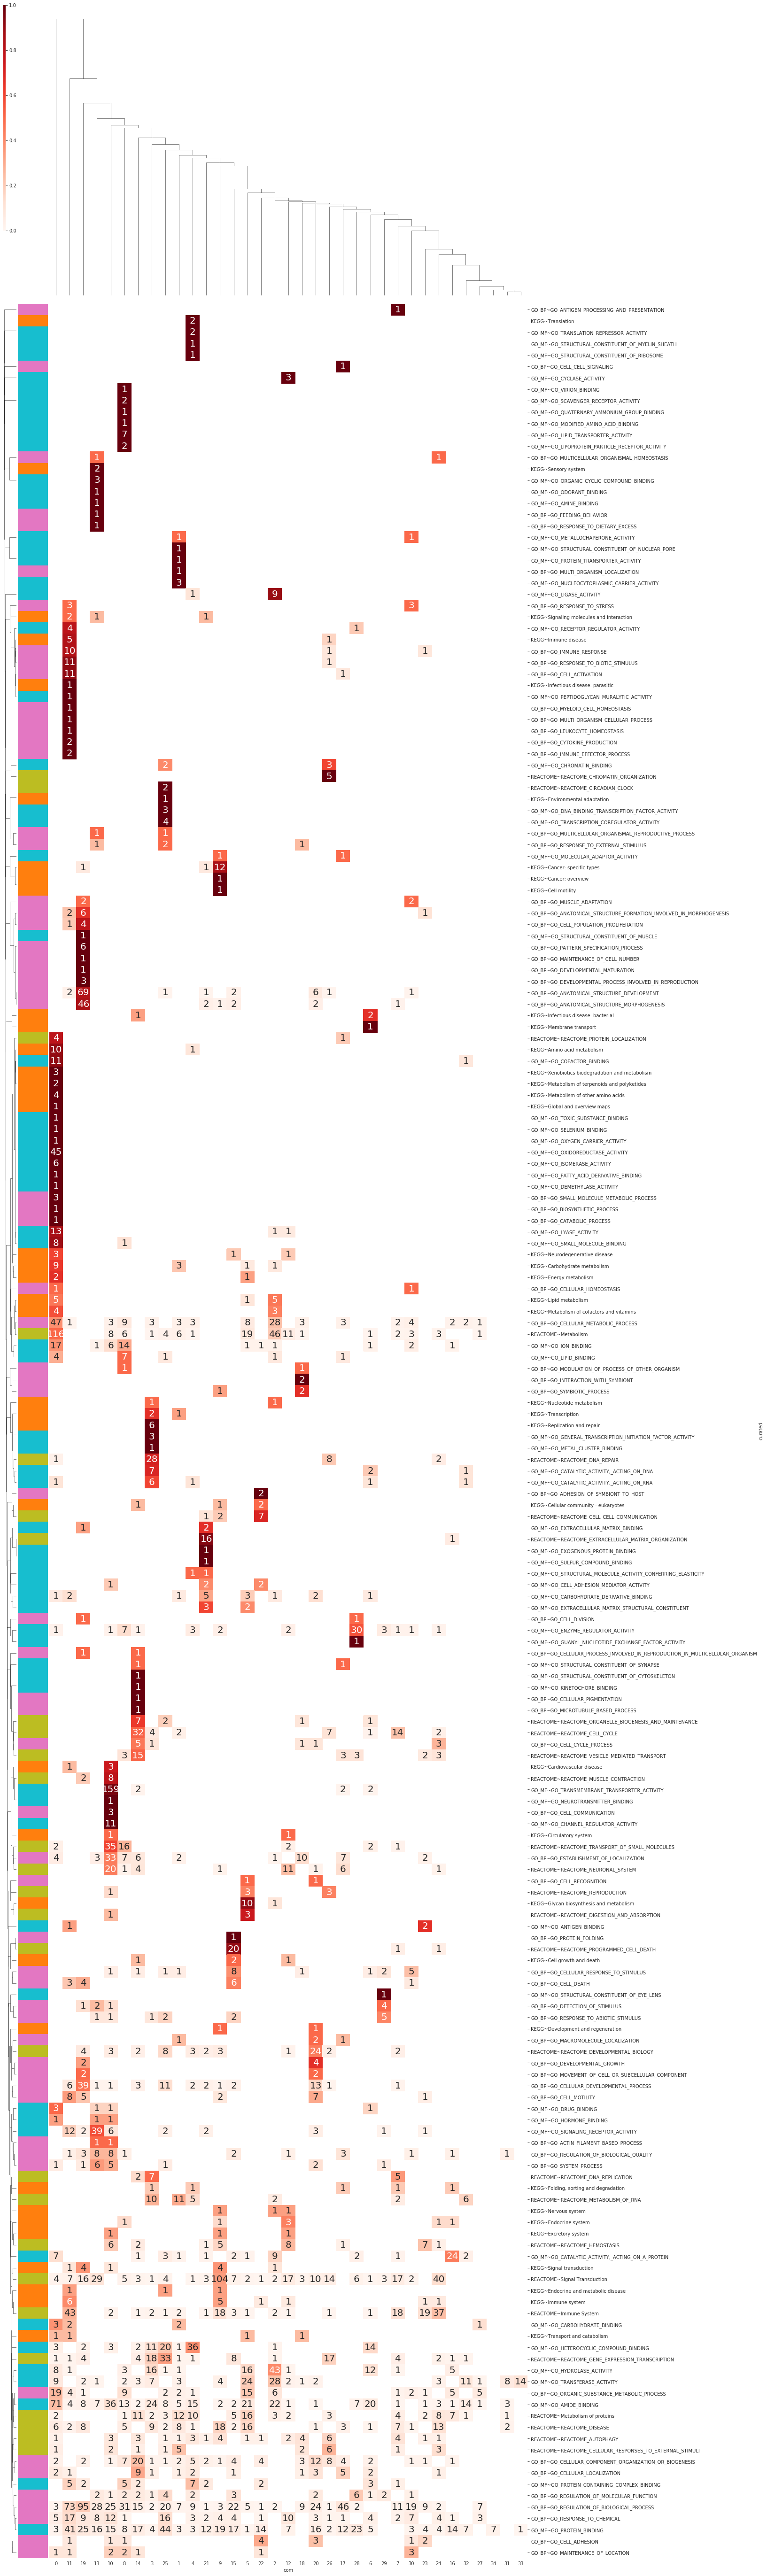

In [13]:
cols_to_idx = np.array(com_v_curated.columns)


toplot = (com_v_curated[cols_to_idx]/com_v_curated[cols_to_idx].sum()).T

g_0 = sns.clustermap(toplot, cmap="Reds", figsize=(20,10), mask=(toplot==0), annot=True, fmt=".2f", 
               annot_kws={"fontsize":10, "fontfamily": "sans-serif"})


new_row_idx = g_0.dendrogram_row.reordered_ind
new_row_order = np.array(toplot.index)[new_row_idx]
new_col_idx = g_0.dendrogram_col.reordered_ind
new_col_order = np.array(toplot.columns)[new_col_idx]

labels = copy.deepcopy(com_v_curated.T)
for col in labels.columns:
    labels[col] = labels[col].apply(lambda x: format_annot(x,2))
row_colors = [database_colors[x.split("~")[0]] for x in toplot.index]
g = sns.clustermap(toplot,cmap="Reds", figsize=(20,100), mask=(toplot==0), annot=labels.loc[new_row_order, new_col_order],
                   fmt="s",  annot_kws={"fontsize":20, "fontfamily": "sans-serif"}, row_colors=row_colors) 
